<a href="https://colab.research.google.com/github/es162008087/DonateASAP/blob/main/Tesis_Maestria_Alvaro_Toriz_23_sep_2025_completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import subprocess
import pandas as pd
import chardet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
enron_urls = [
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz',
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron2.tar.gz',
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron3.tar.gz',
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron4.tar.gz',
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron5.tar.gz',
    'http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron6.tar.gz'
]

for url in enron_urls:
    filename = url.split('/')[-1]
    folder = filename.replace('.tar.gz', '')

    if not os.path.exists(filename):
        print(f'Descargando {filename}...')
        subprocess.run(['wget', url, '-O', filename], check=True)

    if not os.path.exists(folder):
        print(f'Extrayendo {filename}...')
        subprocess.run(['tar', 'xf', filename], check=True)
        print(f'{filename} extraído correctamente.')


Descargando enron1.tar.gz...
Extrayendo enron1.tar.gz...
enron1.tar.gz extraído correctamente.
Descargando enron2.tar.gz...
Extrayendo enron2.tar.gz...
enron2.tar.gz extraído correctamente.
Descargando enron3.tar.gz...
Extrayendo enron3.tar.gz...
enron3.tar.gz extraído correctamente.
Descargando enron4.tar.gz...
Extrayendo enron4.tar.gz...
enron4.tar.gz extraído correctamente.
Descargando enron5.tar.gz...
Extrayendo enron5.tar.gz...
enron5.tar.gz extraído correctamente.
Descargando enron6.tar.gz...
Extrayendo enron6.tar.gz...
enron6.tar.gz extraído correctamente.


In [ ]:
data = {'subject': [], 'body': [], 'classification': []}

for i in range(1, 7):
    enron_dir = f'enron{i}'
    spam_dir = os.path.join(enron_dir, 'spam')
    ham_dir = os.path.join(enron_dir, 'ham')

    for dir_path, _, file_names in os.walk(spam_dir):
        for file_name in file_names:
            file_path = os.path.join(dir_path, file_name)
            with open(file_path, 'rb') as f:
                result = chardet.detect(f.read())
                encoding = result['encoding']
            with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
                subject = f.readline().strip()
                body = f.read().strip()
            data['subject'].append(subject)
            data['body'].append(body)
            data['classification'].append('spam')

    for dir_path, _, file_names in os.walk(ham_dir):
        for file_name in file_names:
            file_path = os.path.join(dir_path, file_name)
            with open(file_path, 'rb') as f:
                result = chardet.detect(f.read())
                encoding = result['encoding']
            with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
                subject = f.readline().strip()
                body = f.read().strip()
            data['subject'].append(subject)
            data['body'].append(body)
            data['classification'].append('ham')

df = pd.DataFrame(data)
df.to_csv('emails.csv', index=False)
print('Dataset de Enron guardado como emails.csv')


Dataset de Enron guardado como emails.csv


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['body'], df['classification'], test_size=0.3, random_state=42, stratify=df['classification'])

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

modelos = {
    'Naive_Bayes': MultinomialNB(),
    'SVM': SVC(probability=True),
    'Decision_Tree': DecisionTreeClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'MLP': MLPClassifier(hidden_layer_sizes=(30,), max_iter=300, solver='adam', random_state=42),
    'Gradient_Boosting': GradientBoostingClassifier()
}

metricas = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train_vectorized, y_train)
    y_pred = modelo.predict(X_test_vectorized)
    metricas[nombre] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label='spam', zero_division=1),
        'Recall': recall_score(y_test, y_pred, pos_label='spam', zero_division=1),
        'F1-Score': f1_score(y_test, y_pred, pos_label='spam', zero_division=1)
    }
    joblib.dump(modelo, f'{nombre}.joblib')

joblib.dump(vectorizer, 'vectorizer.joblib')

df_metricas = pd.DataFrame(metricas).T
print('Métricas de evaluación:')
print(df_metricas)


Métricas de evaluación:
                   Accuracy  Precision    Recall  F1-Score
Naive_Bayes        0.986653   0.988318  0.985440  0.986877
SVM                0.988433   0.981078  0.996506  0.988732
Decision_Tree      0.955314   0.954010  0.958455  0.956227
Random_Forest      0.982897   0.981804  0.984663  0.983232
MLP                0.991498   0.989751  0.993593  0.991668
Gradient_Boosting  0.956401   0.931635  0.986799  0.958424


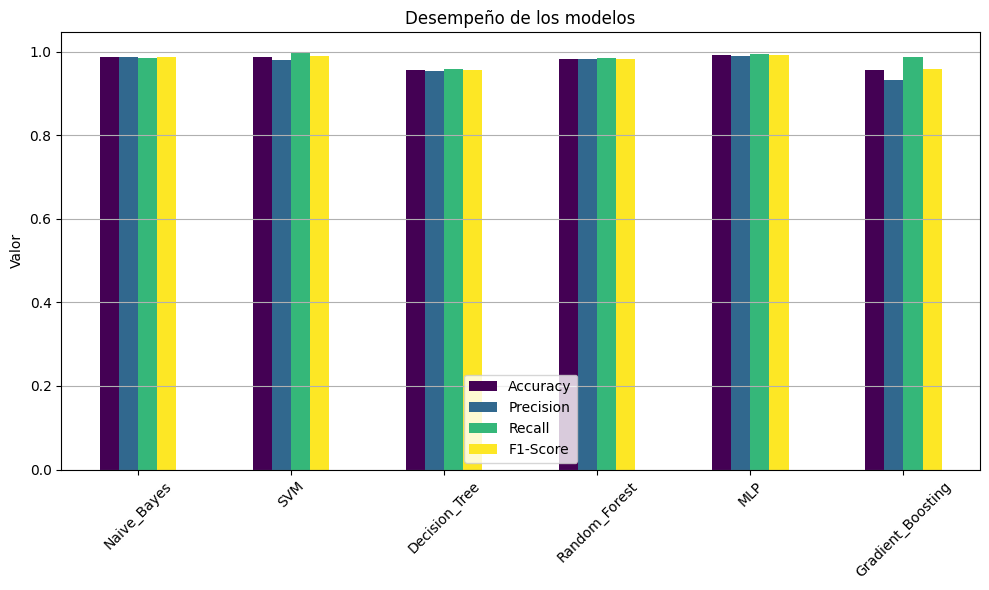

In [ ]:
df_metricas.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Desempeño de los modelos')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('metricas_modelos.png')
plt.show()


In [ ]:
os.makedirs("matrices_confusion", exist_ok=True)

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test_vectorized)
    cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.title(f'Matriz de confusión - {nombre.replace("_", " ")}')
    plt.xlabel('Etiqueta de predicción')
    plt.ylabel('Etiqueta real')
    plt.tight_layout()
    filename = f'matrices_confusion/matriz_{nombre}.png'
    plt.savefig(filename)
    plt.close()

print("Matrices de confusión guardadas en carpeta 'matrices_confusion'.")


Matrices de confusión guardadas en carpeta 'matrices_confusion'.
